In [21]:
import sys
sys.path.append('..')

In [22]:
from model import ForestFire
from mesa import batch_run
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import contextlib

## Single Run

I conducted three single-run simulations by varying four variables: tree density, the number of burned-out trees, the number of flammable trees in fine condition, and the number of resistant trees in fine condition. The results are illustrated in the plots below.

*Low Version (Plot 1)*: This simulation used the lowest settings for all variables, which restricted the fire's ability to spread significantly. As seen in the plot, there are minimal changes in the tree conditions over the simulation steps, indicating a subdued fire spread due to the low variable settings.

*Average Version (Plot 2)*: The medium settings took approximately 50 steps to complete the simulation, the longest among the three scenarios. This configuration allowed the fire to continue spreading, albeit not rapidly enough to speed up the process significantly. Around step 30, the rate of spreading began to slow down, evidenced by the flattening slope of the gray area representing burned-out trees. This suggests that while the increased levels of variables facilitated fire spread, they were not sufficiently high to accelerate it throughout the simulation.

*High Version (Plot 3)*: With the highest settings, the duration required to complete the simulation was notably shorter—25 steps compared to 50 in the average version. The fire spread consistently at a high pace throughout the simulation. The elevated variable settings provided more opportunity for rapid fire spreading, significantly reducing the time to burn out the forest compared to the other versions.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

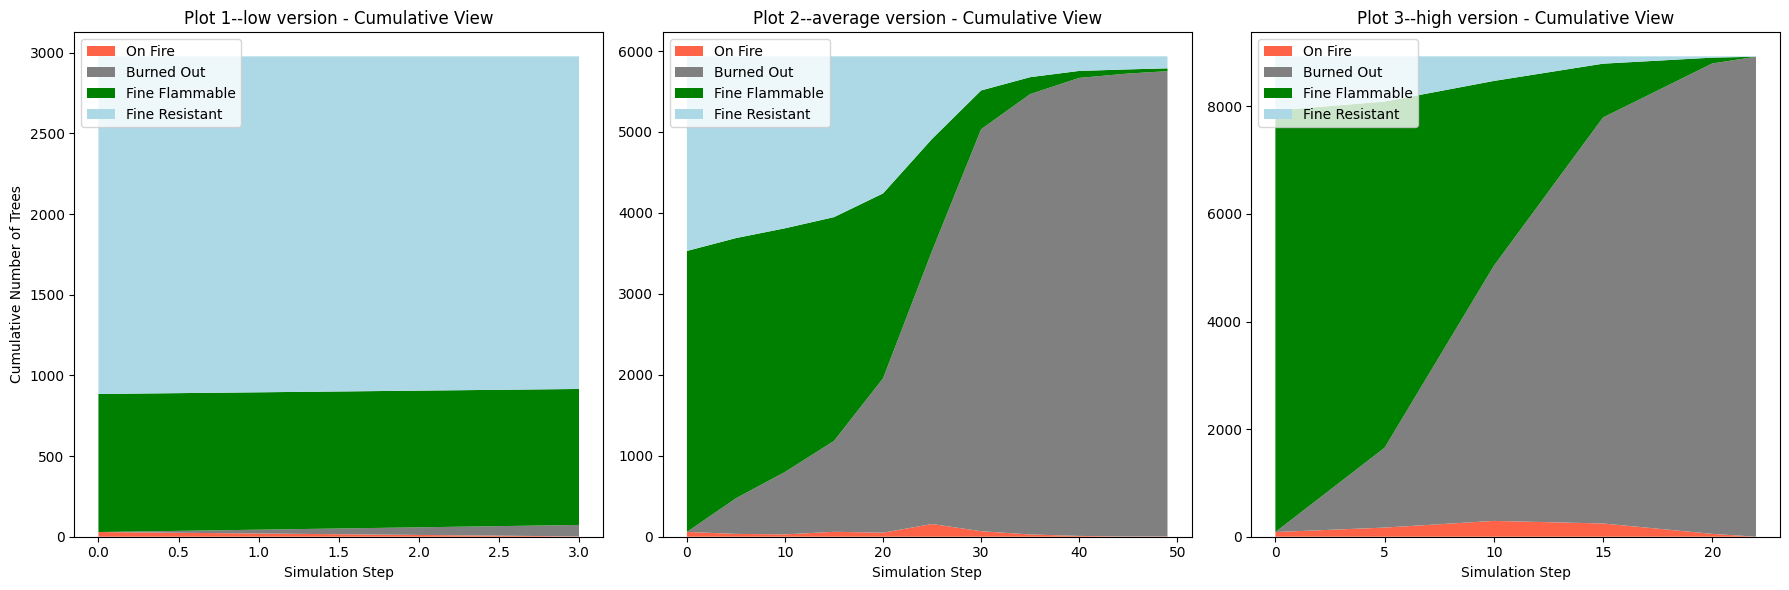

In [33]:

parameter_sets = {
    'Plot 1--low version': {
        "height": 100,
        "width": 100,
        "density": 0.3,
        "Flammable_ratio": 30,
        "wind_chance": 10,
        "wind_radius": 5
    },
    'Plot 2--average version': {
        "height": 100,
        "width": 100,
        "density": 0.6,
        "Flammable_ratio": 60,
        "wind_chance": 30,
        "wind_radius": 10
    },
    'Plot 3--high version': {
        "height": 100,
        "width": 100,
        "density": 0.9,
        "Flammable_ratio": 90,
        "wind_chance": 70,
        "wind_radius": 20
    }
}

def run_and_plot_simulation():
    # Setup for subplots: 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

    for idx, (scenario, params) in enumerate(parameter_sets.items()):
        results = batch_run(ForestFire, 
                            parameters=params,
                            iterations=1,  
                            data_collection_period=5)
        df = pd.DataFrame(results)
        
        # Plot each scenario in its respective subplot
        axes[idx].stackplot(df['Step'], 
                            df['On Fire'], df['Burned Out'], df['Fine Flammable'], df['Fine Resistant'], 
                            labels=['On Fire', 'Burned Out', 'Fine Flammable', 'Fine Resistant'], 
                            colors=['#ff6347', '#808080', '#008000', '#add8e6'])  
        axes[idx].set_title(f'{scenario} - Cumulative View')
        axes[idx].set_xlabel('Simulation Step')
        if idx == 0:  # Only set the ylabel on the first subplot to avoid repetition
            axes[idx].set_ylabel('Cumulative Number of Trees')
        axes[idx].legend(loc='upper left')

    plt.tight_layout()  
    plt.show()

run_and_plot_simulation()


## Batch Run

I conducted a batch run by varying four variables: tree density, the number of burned-out trees, the number of flammable trees in fine condition, and the number of resistant trees in fine condition. Each variable was adjusted across 4 to 5 values to capture significant variations that cover a wide range of scenarios without overwhelming the computer's capabilities. I omitted the max_steps parameter because the forest fire simulations naturally conclude when there are no more trees on fire. I also omitted the data_collection_period to only gather data at the final step of each iteration, allowing me to determine the number of steps required to end each forest fire. Both the height and width of the grid are set to 100, meaning there can be up to 10,000 trees at maximum when the density is 1. The batch run take 226 mins(around 4 hours), originally take 24 hours before using parallel processing.

In [ ]:
# Get the number of CPUs available
num_cores = os.cpu_count()
print(num_cores)

parameters = {
    "height": 100,
    "width": 100,
    "density": np.linspace(0.01, 1, 4),  
    "Flammable_ratio": np.linspace(0, 100, 5),
    "wind_chance": np.linspace(0, 100, 5),  
    "wind_radius": np.linspace(1, 31, 5)  
}

results = batch_run(ForestFire, 
                    parameters,
                    iterations=50,  
                    # max_steps=30,  
                    # data_collection_period=100,
					number_processes=num_cores - 5)  # changed this base on available CPU

# it takes 226 mins in total
df = pd.DataFrame(results)
df.to_csv("batch_data.csv") 


## Plotting

I use plots to demonstrate how forest fire and winds' influence on quantity(the number/percentage of burned out trees) and time spend(steps taken)

**Wind Influence on Forest Fires**
I first utilized a heatmap to evaluate the effect of wind chance and radius on the number of burned-out trees. By multiplying these two variables, I examined their combined influence on the outcome. As observed in the heatmap, the number of burned-out trees tends to reach its maximum when both wind chance and radius are at their highest values. This suggests that the impact of the forest fire increases as both the chance of wind occurrence and its radius increase. The visualization clearly demonstrates how stronger and more extensive wind conditions can enhance the spread and intensity of the fire, resulting in a greater number of trees burned.

In [9]:
df = pd.read_csv('batch_data.csv')

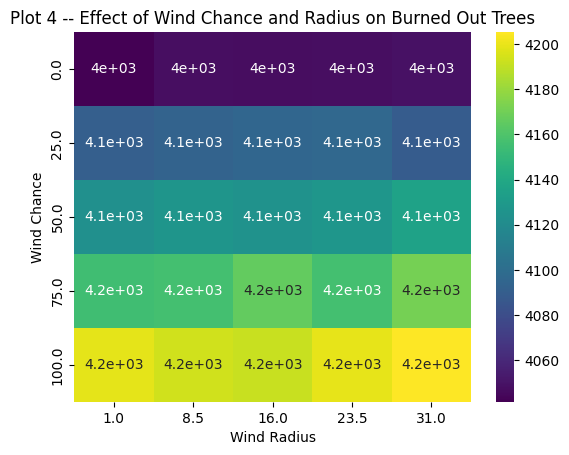

In [10]:
import seaborn as sns

heatmap_data = df.pivot_table(values='Burned Out', index='wind_chance', columns='wind_radius', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='viridis', annot=True)
plt.title('Plot 4 -- Effect of Wind Chance and Radius on Burned Out Trees')
plt.xlabel('Wind Radius')
plt.ylabel('Wind Chance')
plt.show()

**Wind Influence on Fire Spread Duration**
Plot 5 illustrates the impact of wind on the duration of forest fire simulations. As observed, the average number of simulation steps decreases as the product of wind chance and radius increases, indicating that stronger and more extensive wind conditions facilitate faster fire spreading. This is reflected by the decreasing trend in the number of steps required to complete the simulations with increasing wind influence.

However, there is an unusual increase in the average simulation steps at the second data point, which suggests potential variability in the data. This could be due to a relatively small sample size for each set of parameters (50 iterations per set may not be sufficient to achieve statistical convergence) or an unidentified pattern affecting the results. Given the constraints on computation resources and time, a more in-depth analysis was not feasible at this time for this part of the data, which might have provided clearer insights into this anomaly.

C:\Users\Janet\AppData\Local\Temp\ipykernel_14468\2472557561.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Wind Interaction Bin')['Step'].agg(['mean', 'size']).reset_index()


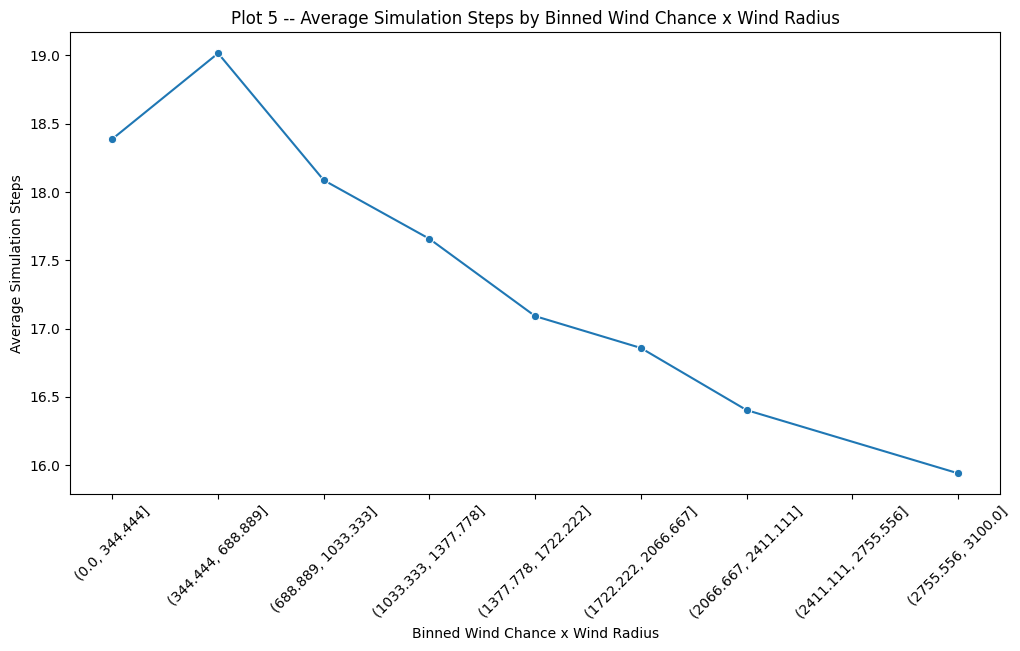

In [14]:
df['Wind Interaction'] = df['wind_chance'] * df['wind_radius']
df['Wind Interaction Bin'] = pd.cut(df['Wind Interaction'], bins=np.linspace(df['Wind Interaction'].min(), df['Wind Interaction'].max(), num=10))

# Calculating the mean and count of steps for each bin
grouped = df.groupby('Wind Interaction Bin')['Step'].agg(['mean', 'size']).reset_index()
grouped.rename(columns={'mean': 'Average Steps', 'size': 'Count'}, inplace=True)

# Convert 'Wind Interaction Bin' to string for better plotting
grouped['Wind Interaction Bin'] = grouped['Wind Interaction Bin'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Wind Interaction Bin', y='Average Steps', marker='o')
plt.title('Plot 5 -- Average Simulation Steps by Binned Wind Chance x Wind Radius')
plt.xlabel('Binned Wind Chance x Wind Radius')
plt.ylabel('Average Simulation Steps')
plt.xticks(rotation=45)

plt.show()


**Further Analysis for Wind Influence on Fire Spread Duration** Let's delve deeper to wind's influence.In this updated plot, I've incorporated error bars to represent the standard deviation around each data point, providing a clearer picture of the variability in the number of simulation steps. The standard deviation ranges significantly, from approximately 2 to 35, which is quite substantial compared to the average step count of around 18. This wide range in variation indicates that factors other than wind may be more influential in determining the duration of forest fires in our simulations.

The decreasing standard deviation with increased wind influence hints that while wind may not be the most dominant factor, its presence does contribute to a slight reduction in variability and simulation duration.

C:\Users\Janet\AppData\Local\Temp\ipykernel_14468\2506102934.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Wind Interaction Bin')['Step'].agg(['mean', 'std', 'size']).reset_index()
C:\Users\Janet\AppData\Local\Temp\ipykernel_14468\2506102934.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=grouped, x='Wind Interaction Bin', y='Average Steps', marker='o', ci='sd')


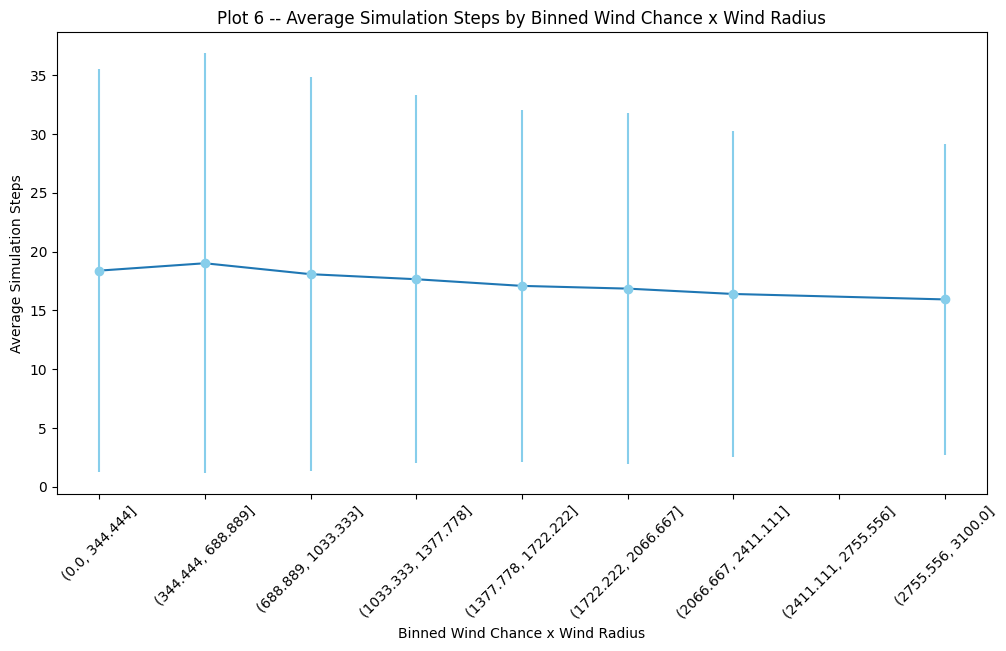

In [15]:
df['Wind Interaction Bin'] = pd.cut(df['Wind Interaction'], bins=np.linspace(df['Wind Interaction'].min(), df['Wind Interaction'].max(), num=10))

# Calculating the mean and standard deviation of steps for each bin
grouped = df.groupby('Wind Interaction Bin')['Step'].agg(['mean', 'std', 'size']).reset_index()
grouped.rename(columns={'mean': 'Average Steps', 'std': 'Std Steps', 'size': 'Count'}, inplace=True)

# Convert 'Wind Interaction Bin' to string for better plotting
grouped['Wind Interaction Bin'] = grouped['Wind Interaction Bin'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Wind Interaction Bin', y='Average Steps', marker='o', ci='sd')

plt.errorbar(grouped['Wind Interaction Bin'], grouped['Average Steps'], yerr=grouped['Std Steps'], fmt='o', color='skyblue')

plt.title('Plot 6 -- Average Simulation Steps by Binned Wind Chance x Wind Radius')
plt.xlabel('Binned Wind Chance x Wind Radius')
plt.ylabel('Average Simulation Steps')
plt.xticks(rotation=45)

plt.show()



**Flammable Tree Ratio's influence on simulation duration** Plot 7 illustrates the impact of varying flammable tree ratios on the duration of forest fire simulations. Similar to previous observations, there is a noticeable trend of decreasing average simulation steps as the flammable tree ratio increases. This suggests that a higher proportion of flammable trees may facilitate faster fire spread, potentially reducing the overall duration of simulations.

However, the standard deviation (Std Dev) associated with the average steps is relatively large compared to the mean values, indicating significant variability in simulation outcomes. Notably, the standard deviation decreases as the flammable tree ratio increases, suggesting that higher flammable ratios not only shorten simulation times but also reduce variability in the number of steps required to complete the simulations.

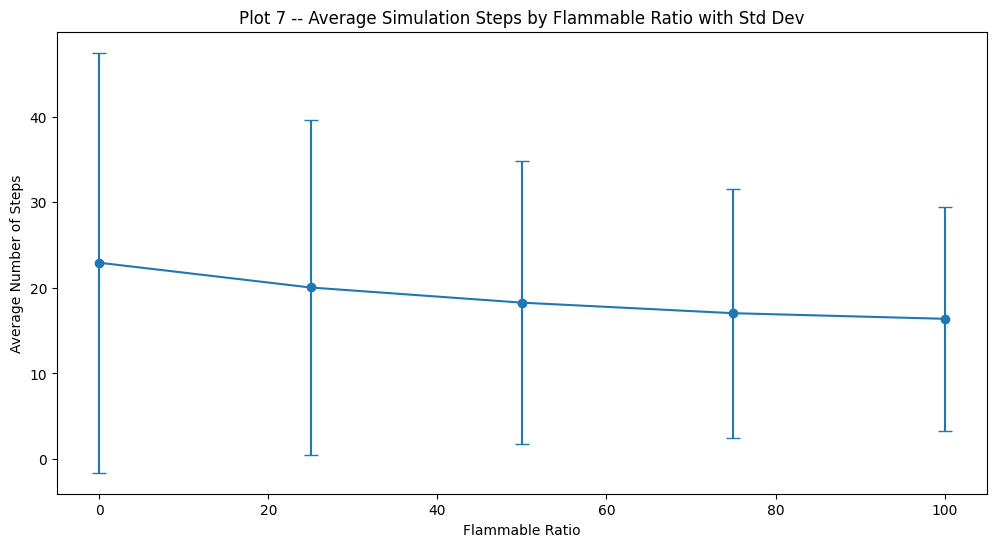

In [16]:

# Calculate mean and standard deviation of steps for each Flammable_ratio
grouped_flammable = df.groupby('Flammable_ratio')['Step'].agg(['mean', 'std']).reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.errorbar(grouped_flammable['Flammable_ratio'], grouped_flammable['mean'], yerr=grouped_flammable['std'], fmt='-o', capsize=5)
plt.title('Plot 7 -- Average Simulation Steps by Flammable Ratio with Std Dev')
plt.xlabel('Flammable Ratio')
plt.ylabel('Average Number of Steps')

plt.show()



**Density's Influence on Simulation Duration and Burn-Out** 
Plots 8 and 9 illustrate the impact of tree density on the duration of forest fire simulations and the percentage of trees burned out.

Low to Medium Density (0.0 to 0.6): In these plots, as tree density increases from low to medium, we observe a steady increase in the average number of simulation steps. This suggests that the fire has more material to spread to, thus extending the duration of the simulation. However, at medium densities around 0.6, while the number of steps peaks, the bubble size in Plot 9 does not reach its maximum. This indicates that although the fire spreads for a longer duration, it does not manage to consume all available trees. The fire spreads slower due to moderately spaced trees, and often extinguishes before it can completely burn through the forest, leaving many trees unburned.

High Density (0.6 to 1.0): Beyond the medium density, the number of simulation steps decreases as depicted in Plot 8, reflecting a quicker spread of the fire due to the close proximity of trees. This rapid spread leads to a more extensive burn-out as more trees are quickly consumed by the fire, which is corroborated by the largest bubble at a density of 1.0 in Plot 9. This shows that the highest density settings result in the most substantial burn-out, indicating that the fire efficiently spreads across nearly all trees.

Standard Deviataion: Plot 8 demonstrate a much smaller std compare to pervious plots, indicating that density plays a more substantial role in influencing forest fire spreading than flammable tree ratio and wind. Also, we see relatively greater std at medium density, showing that the low and high density are extreme condition for fire spreading, fires either extinguish too soon or burn out all available trees very quickly. The medium condition leaves more room for other elements to play a part. 

C:\Users\Janet\AppData\Local\Temp\ipykernel_14468\1269084734.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(grouped['density'], grouped['Mean_Steps'], yerr=grouped['Std_Steps'], fmt='-o', ecolor='blue', capsize=5, linestyle='-', marker='o', color='blue')
C:\Users\Janet\AppData\Local\Temp\ipykernel_14468\1269084734.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(grouped['density'], grouped['Mean_Steps'], yerr=grouped['Std_Steps'], fmt='-o', ecolor='blue', capsize=5, linestyle='-', marker='o', color='blue')


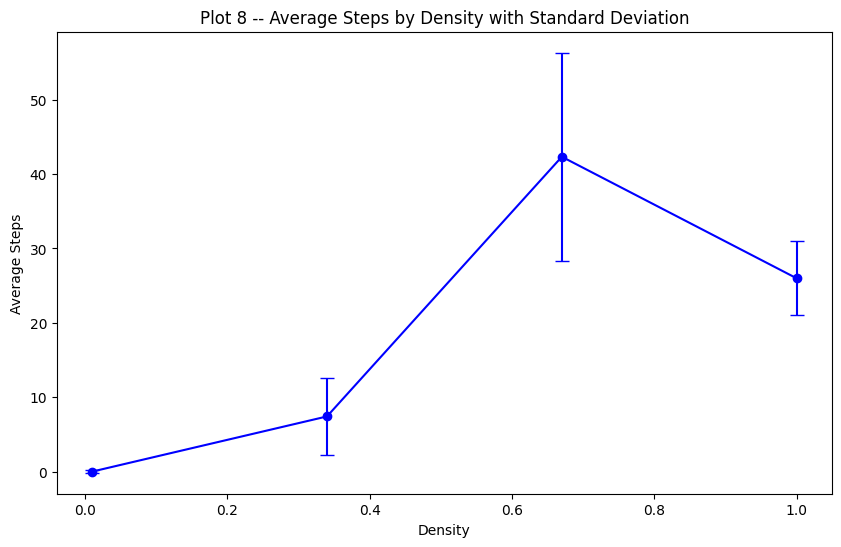

In [17]:

grouped = df.groupby('density')['Step'].agg(['mean', 'std']).reset_index()
grouped.rename(columns={'mean': 'Mean_Steps', 'std': 'Std_Steps'}, inplace=True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.errorbar(grouped['density'], grouped['Mean_Steps'], yerr=grouped['Std_Steps'], fmt='-o', ecolor='blue', capsize=5, linestyle='-', marker='o', color='blue')
plt.title('Plot 8 -- Average Steps by Density with Standard Deviation')
plt.xlabel('Density')
plt.ylabel('Average Steps')

plt.show()


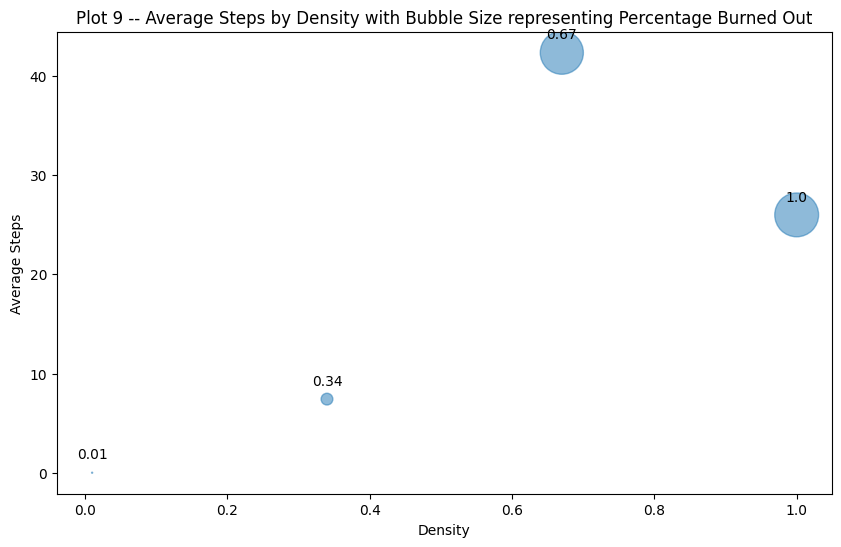

In [20]:
# Calculate percentage burned out
df['Percentage_Burned_Out'] = (df['Burned Out'] / (df['On Fire'] + df['Burned Out']+ df['Fine Flammable']+ df['Fine Resistant'])) * 100
# Aggregate data by density
grouped = df.groupby('density').agg({
    'Step': 'mean',
    'Percentage_Burned_Out': 'mean'
}).reset_index()
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

# Calculate bubble sizes based on percentage burned out
bubble_sizes = grouped['Percentage_Burned_Out'] * 10  # Adjust the scale factor as needed for better visualization

# Plot the line with bubble sizes
plt.scatter(grouped['density'], grouped['Step'], s=bubble_sizes, alpha=0.5)

# Annotate each bubble with the density value
for i, txt in enumerate(grouped['density']):
    plt.annotate(txt, (grouped['density'][i], grouped['Step'][i]), textcoords="offset points", xytext=(0,10), ha='center')

# Add labels and title
plt.title('Plot 9 -- Average Steps by Density with Bubble Size representing Percentage Burned Out')
plt.xlabel('Density')
plt.ylabel('Average Steps')


plt.show()


**Reflection on Model Design and Suitability**
The overall design of the model effectively captures real-world elements and mechanisms of forest fire spreading. Observing the inverted U-shaped curve in the duration of forest fires—an unexpected but realistic outcome—demonstrates the model's ability to reveal complex phenomena that mirror actual fire behavior.
*Single Run*: The model provides detailed insights into the dynamics of forest fire spread under specific conditions, which is important for in-depth analysis of particular scenarios.
*Batch Run*: In batch runs, the model's capacity to handle varied input parameters efficiently allows for extensive testing across a wide range of scenarios, which is crucial for statistical analysis and understanding broader trends and outliers within the data.

*Potential for Model Optimization*:
Although the model performs well, there is potential to enhance its efficiency, particularly for batch runs where computational time can accumulate:
Optimizing Agent Interaction: Consider reduce the complexity of agents interaction machinism in a meaningful way.
Optimizing coding: Go through the code to find and remove any steps that repeat without need or parts that aren't doing much. This includes combining functions that do similar things, getting rid of extra code, and making sure the most straightforward methods are used for tasks.